# Imports Libraries  


In [1]:
import os
import shutil
import random
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models.video as models
from torchvision.models.video import r3d_18, R3D_18_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm



#  Reproducibility 

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Dataset Copy + Clean 

In [4]:
def copy_and_clean_dataset(src_root, dst_root):
    if os.path.exists(dst_root):
        print("Dataset already copied and cleaned.")
        return

    print("Copying dataset...")
    shutil.copytree(src_root, dst_root)
    print("Copied.")

    print("Cleaning corrupted videos...")
    for cls in ["Violence", "NonViolence"]:
        cls_dir = os.path.join(dst_root, cls)
        for video in tqdm(os.listdir(cls_dir), desc=f"Cleaning {cls}"):
            path = os.path.join(cls_dir, video)
            cap = cv2.VideoCapture(path)
            for _ in range(16):
                ret, frame = cap.read()
                if not ret:
                    os.remove(path)
                    break
            cap.release()



#  Dataset Split 

In [5]:
def split_dataset(root_dir, train_dir, val_dir, split_ratio=0.8):
    print("Splitting dataset...")
    for cls in ["Violence", "NonViolence"]:
        videos = os.listdir(os.path.join(root_dir, cls))
        random.shuffle(videos)
        split_idx = int(split_ratio * len(videos))
        train_videos = videos[:split_idx]
        val_videos = videos[split_idx:]

        for target_dir, video_list in [(train_dir, train_videos), (val_dir, val_videos)]:
            cls_target = os.path.join(target_dir, cls)
            os.makedirs(cls_target, exist_ok=True)
            for video in video_list:
                src = os.path.join(root_dir, cls, video)
                dst = os.path.join(cls_target, video)
                shutil.copy2(src, dst)


#  Dataset Class 

In [6]:
class ViolenceDataset(Dataset):
    def __init__(self, root_dir, transform=None, frames_per_clip=8):
        self.root_dir = root_dir
        self.transform = transform
        self.frames_per_clip = frames_per_clip
        self.video_paths = []
        self.labels = []

        for label, folder in enumerate(sorted(os.listdir(root_dir))):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                for file in os.listdir(folder_path):
                    if file.endswith(".mp4") or file.endswith(".avi"):
                        self.video_paths.append(os.path.join(folder_path, file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        try:
            frames = self._read_video(video_path)
        except Exception as e:
            print(f"Skipping corrupt video: {video_path}")
            return self.__getitem__((idx + 1) % len(self))

        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        frames_tensor = torch.stack(frames).permute(1, 0, 2, 3)
        return frames_tensor, label

    def _read_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            cap.release()
            raise RuntimeError(f"Failed to open video: {video_path}")

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames < self.frames_per_clip:
            frame_indices = np.concatenate([
                np.arange(total_frames),
                np.full(self.frames_per_clip - total_frames, total_frames - 1)
            ])
        else:
            frame_indices = np.linspace(0, total_frames - 1, self.frames_per_clip, dtype=int)

        frames = []
        for i in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret or frame is None:
                cap.release()
                raise RuntimeError(f"Corrupt frame in video: {video_path}")
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (112, 112))
            frames.append(torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0)

        cap.release()
        return frames

#  Transforms 

In [7]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


#  Visualize Sample Video Frames

In [8]:

def show_video_sample(dataset, class_name="Violence"):
    # Get first sample that belongs to the desired class
    for video_tensor, label in dataset:
        if dataset.labels[dataset.video_paths.index(dataset.video_paths[dataset.labels.index(label)])] == (0 if class_name == "Violence" else 1):
            print(f"Showing {class_name} sample")
            # Shape: (C, T, H, W) --> (T, H, W, C) for display
            frames = video_tensor.permute(1, 2, 3, 0).cpu().numpy()
            break

    plt.figure(figsize=(15, 3))
    for i in range(min(8, frames.shape[0])):  # Show first 8 frames
        plt.subplot(1, 8, i+1)
        plt.imshow(frames[i])
        plt.axis('off')
    plt.suptitle(f"{class_name} Sample Video Frames", fontsize=14)
    plt.show()



#  Load Dataset and Show Samples 

Showing Violence sample


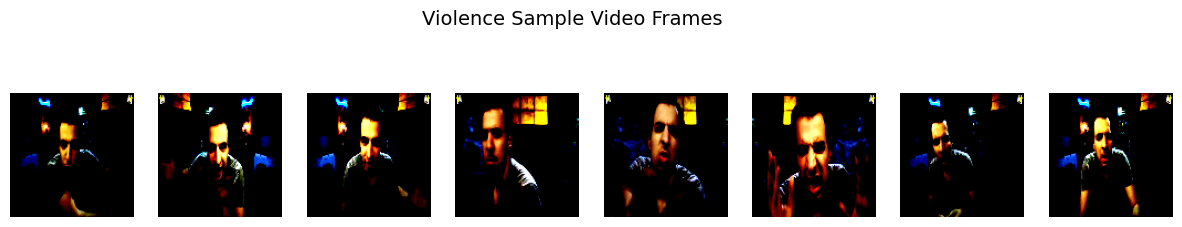

Skipping corrupt video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_357.mp4
Skipping corrupt video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_360.mp4


[h264 @ 0x3da08e80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3da08e80] error while decoding MB 98 31
[h264 @ 0x3da08e80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3da08e80] error while decoding MB 98 31
[h264 @ 0x3da08e80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3da08e80] error while decoding MB 98 31


Skipping corrupt video: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_362.mp4
Showing NonViolence sample


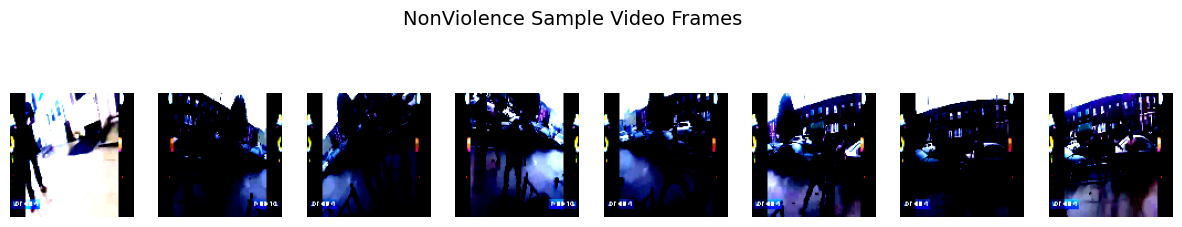

In [9]:
sample_dataset = ViolenceDataset(root_dir="/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset", transform=transform, frames_per_clip=16)

show_video_sample(sample_dataset, class_name="Violence")
show_video_sample(sample_dataset, class_name="NonViolence")

#  Data Loaders 

In [10]:
def get_loaders(train_dir, val_dir, batch_size=4, num_workers=2):
    train_set = ViolenceDataset(train_dir, transform=transform)
    val_set = ViolenceDataset(val_dir, transform=transform)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True, persistent_workers=True)
    return train_loader, val_loader



#  Modelling

In [11]:
def build_model(num_classes=2):
    weights = R3D_18_Weights.DEFAULT
    model = r3d_18(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

#  Training Loop

In [12]:
def train(model, train_loader, val_loader, num_epochs=15, lr=1e-4):
    class_counts = np.bincount(train_loader.dataset.labels)
    class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
    scaler = torch.cuda.amp.GradScaler()

    best_val_loss = float('inf')
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(videos)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for videos, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                videos, labels = videos.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(videos)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Val Loss: {avg_val_loss:.4f} Val Acc: {val_acc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pth")

        scheduler.step(avg_val_loss)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.savefig("loss_curve.png")

    plt.figure()
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.savefig("accuracy_curve.png")


#  Runing  The code 

Copying dataset...
Copied.
Cleaning corrupted videos...


Cleaning NonViolence: 100%|██████████| 1000/1000 [00:14<00:00, 69.41it/s]


Splitting dataset...


Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 175MB/s]  
/tmp/ipykernel_35/2982562397.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/15 [Train]:   0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_35/2982562397.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/15 [Train]:  42%|████▏     | 168/400 [02:56<05:03,  1.31s/it]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 1/15 [Train]:  54%|█████▎    | 214/400 [03:47<03:49,  1.23s/it][h264 @ 0x3db99e00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3db99e00] error while decoding MB 98 31
Epoch 1/15 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_35/2982562397.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/15 [Val]:  26%|██▌       | 26/100 [00:20<00:47,  1.56it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 1/15 [Val]:  31%|███       | 31/100 [00:20<00:20,  3.34it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 1/15 [Val]:  95%|█████████▌| 95/100 [01:36<00:05,  1.19s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 1/15 [Val]: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


Epoch [1/15] Train Loss: 0.4304 Val Loss: 0.1932 Val Acc: 0.9225


Epoch 2/15 [Train]:  82%|████████▏ | 328/400 [05:40<02:04,  1.72s/it]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 2/15 [Train]:  95%|█████████▌| 381/400 [06:27<00:21,  1.12s/it][h264 @ 0x3ef8c5c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3ef8c5c0] error while decoding MB 98 31
Epoch 2/15 [Val]:  24%|██▍       | 24/100 [00:17<00:43,  1.74it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 2/15 [Val]:  31%|███       | 31/100 [00:19<00:19,  3.50it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 2/15 [Val]:  95%|█████████▌| 95/100 [01:35<00:06,  1.21s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 2/15 [Val]: 100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


Epoch [2/15] Train Loss: 0.3204 Val Loss: 0.1968 Val Acc: 0.9175


Epoch 3/15 [Train]:  12%|█▎        | 50/400 [00:53<05:20,  1.09it/s][h264 @ 0x3dd98a40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3dd98a40] error while decoding MB 98 31
Epoch 3/15 [Train]:  42%|████▏     | 168/400 [02:52<03:30,  1.10it/s]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 3/15 [Val]:  24%|██▍       | 24/100 [00:18<00:45,  1.66it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 3/15 [Val]:  31%|███       | 31/100 [00:21<00:20,  3.41it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 3/15 [Val]:  95%|█████████▌| 95/100 [01:37<00:05,  1.19s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 3/15 [Val]: 100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


Epoch [3/15] Train Loss: 0.2743 Val Loss: 0.1514 Val Acc: 0.9400


Epoch 4/15 [Train]:  33%|███▎      | 133/400 [02:17<04:55,  1.11s/it][h264 @ 0x3db9b9c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3db9b9c0] error while decoding MB 98 31
Epoch 4/15 [Train]:  86%|████████▌ | 342/400 [05:55<00:50,  1.15it/s]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 4/15 [Val]:  24%|██▍       | 24/100 [00:18<00:43,  1.75it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 4/15 [Val]:  31%|███       | 31/100 [00:20<00:19,  3.50it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 4/15 [Val]:  95%|█████████▌| 95/100 [01:36<00:05,  1.20s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 4/15 [Val]: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


Epoch [4/15] Train Loss: 0.2437 Val Loss: 0.2061 Val Acc: 0.9300


Epoch 5/15 [Train]:  44%|████▍     | 178/400 [03:00<04:30,  1.22s/it][h264 @ 0x3db9a940] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3db9a940] error while decoding MB 98 31
Epoch 5/15 [Train]:  56%|█████▌    | 222/400 [03:51<03:00,  1.01s/it]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 5/15 [Val]:  26%|██▌       | 26/100 [00:19<00:47,  1.57it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 5/15 [Val]:  31%|███       | 31/100 [00:19<00:20,  3.38it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 5/15 [Val]:  95%|█████████▌| 95/100 [01:35<00:06,  1.22s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 5/15 [Val]: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


Epoch [5/15] Train Loss: 0.2219 Val Loss: 0.1457 Val Acc: 0.9500


Epoch 6/15 [Train]:  27%|██▋       | 109/400 [01:38<04:38,  1.05it/s]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 6/15 [Train]:  59%|█████▉    | 237/400 [03:49<03:02,  1.12s/it][h264 @ 0x3dd9a9c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3dd9a9c0] error while decoding MB 98 31
Epoch 6/15 [Val]:  24%|██▍       | 24/100 [00:18<00:43,  1.74it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 6/15 [Val]:  31%|███       | 31/100 [00:20<00:19,  3.50it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 6/15 [Val]:  95%|█████████▌| 95/100 [01:35<00:05,  1.17s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 6/15 [Val]: 100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


Epoch [6/15] Train Loss: 0.2083 Val Loss: 0.1537 Val Acc: 0.9500


Epoch 7/15 [Train]:  28%|██▊       | 111/400 [01:38<06:02,  1.25s/it][h264 @ 0x3e3a5e00] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3e3a5e00] error while decoding MB 98 31
Epoch 7/15 [Train]:  99%|█████████▉| 397/400 [06:39<00:03,  1.20s/it]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 7/15 [Val]:  26%|██▌       | 26/100 [00:20<00:54,  1.36it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 7/15 [Val]:  31%|███       | 31/100 [00:20<00:22,  3.02it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 7/15 [Val]:  95%|█████████▌| 95/100 [01:35<00:06,  1.20s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 7/15 [Val]: 100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


Epoch [7/15] Train Loss: 0.1638 Val Loss: 0.1044 Val Acc: 0.9625


Epoch 8/15 [Train]:   9%|▉         | 35/400 [00:39<06:34,  1.08s/it]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 8/15 [Train]:  20%|██        | 80/400 [01:26<07:08,  1.34s/it][h264 @ 0x3e713bc0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3e713bc0] error while decoding MB 98 31
Epoch 8/15 [Val]:  26%|██▌       | 26/100 [00:19<00:46,  1.58it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 8/15 [Val]:  31%|███       | 31/100 [00:19<00:19,  3.51it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 8/15 [Val]:  95%|█████████▌| 95/100 [01:33<00:05,  1.18s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 8/15 [Val]: 100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


Epoch [8/15] Train Loss: 0.1294 Val Loss: 0.1087 Val Acc: 0.9675


Epoch 9/15 [Train]:  35%|███▍      | 139/400 [02:17<02:29,  1.75it/s][h264 @ 0x3e70c5c0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3e70c5c0] error while decoding MB 98 31
Epoch 9/15 [Train]:  56%|█████▋    | 225/400 [03:47<03:16,  1.13s/it]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 9/15 [Val]:  26%|██▌       | 26/100 [00:18<00:46,  1.60it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 9/15 [Val]:  31%|███       | 31/100 [00:19<00:19,  3.54it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 9/15 [Val]:  95%|█████████▌| 95/100 [01:33<00:05,  1.19s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 9/15 [Val]: 100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


Epoch [9/15] Train Loss: 0.1127 Val Loss: 0.1345 Val Acc: 0.9450


Epoch 10/15 [Train]:  68%|██████▊   | 272/400 [04:30<02:30,  1.18s/it]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 10/15 [Train]:  86%|████████▌ | 343/400 [05:36<00:29,  1.94it/s][h264 @ 0x3ef8dac0] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3ef8dac0] error while decoding MB 98 31
Epoch 10/15 [Val]:  26%|██▌       | 26/100 [00:18<00:46,  1.58it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 10/15 [Val]:  31%|███       | 31/100 [00:19<00:19,  3.60it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 10/15 [Val]:  95%|█████████▌| 95/100 [01:33<00:05,  1.20s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 10/15 [Val]: 100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


Epoch [10/15] Train Loss: 0.1009 Val Loss: 0.1247 Val Acc: 0.9475


Epoch 11/15 [Train]:  35%|███▌      | 141/400 [02:16<04:35,  1.07s/it]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 11/15 [Train]:  71%|███████▏  | 285/400 [04:36<01:26,  1.33it/s][h264 @ 0x3e710b80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3e710b80] error while decoding MB 98 31
Epoch 11/15 [Val]:  26%|██▌       | 26/100 [00:18<00:46,  1.58it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 11/15 [Val]:  31%|███       | 31/100 [00:19<00:20,  3.43it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 11/15 [Val]:  95%|█████████▌| 95/100 [01:33<00:05,  1.18s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 11/15 [Val]: 100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


Epoch [11/15] Train Loss: 0.0652 Val Loss: 0.0868 Val Acc: 0.9675


Epoch 12/15 [Train]:  14%|█▍        | 55/400 [00:58<05:04,  1.13it/s][h264 @ 0x3e70ed40] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3e70ed40] error while decoding MB 98 31
Epoch 12/15 [Train]:  78%|███████▊  | 311/400 [04:57<00:47,  1.89it/s]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 12/15 [Val]:  24%|██▍       | 24/100 [00:17<00:46,  1.65it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 12/15 [Val]:  31%|███       | 31/100 [00:20<00:20,  3.36it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 12/15 [Val]:  95%|█████████▌| 95/100 [01:33<00:05,  1.17s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 12/15 [Val]: 100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


Epoch [12/15] Train Loss: 0.0577 Val Loss: 0.0828 Val Acc: 0.9700


Epoch 13/15 [Train]:  52%|█████▏    | 207/400 [03:33<03:51,  1.20s/it]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 13/15 [Train]:  66%|██████▋   | 266/400 [04:34<02:35,  1.16s/it][h264 @ 0x3e711d80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3e711d80] error while decoding MB 98 31
Epoch 13/15 [Val]:  26%|██▌       | 26/100 [00:19<00:47,  1.56it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 13/15 [Val]:  31%|███       | 31/100 [00:20<00:20,  3.38it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 13/15 [Val]:  95%|█████████▌| 95/100 [01:35<00:05,  1.20s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 13/15 [Val]: 100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


Epoch [13/15] Train Loss: 0.0368 Val Loss: 0.0731 Val Acc: 0.9775


Epoch 14/15 [Train]:  46%|████▌     | 184/400 [03:05<03:03,  1.18it/s][h264 @ 0x3e2ba500] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3e2ba500] error while decoding MB 98 31
Epoch 14/15 [Train]:  55%|█████▍    | 218/400 [03:39<03:39,  1.21s/it]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 14/15 [Val]:  26%|██▌       | 26/100 [00:19<00:46,  1.59it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 14/15 [Val]:  31%|███       | 31/100 [00:19<00:19,  3.50it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 14/15 [Val]:  95%|█████████▌| 95/100 [01:32<00:05,  1.15s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 14/15 [Val]: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


Epoch [14/15] Train Loss: 0.0422 Val Loss: 0.0749 Val Acc: 0.9650


Epoch 15/15 [Train]:  40%|███▉      | 158/400 [02:41<02:42,  1.49it/s]

Skipping corrupt video: /kaggle/working/train/NonViolence/NV_360.mp4


Epoch 15/15 [Train]:  95%|█████████▌| 380/400 [06:27<00:14,  1.38it/s][h264 @ 0x3e3a3780] mb_type 104 in P slice too large at 98 31
[h264 @ 0x3e3a3780] error while decoding MB 98 31
Epoch 15/15 [Val]:  26%|██▌       | 26/100 [00:19<00:47,  1.57it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_357.mp4


Epoch 15/15 [Val]:  31%|███       | 31/100 [00:20<00:21,  3.25it/s]

Skipping corrupt video: /kaggle/working/val/NonViolence/NV_362.mp4


Epoch 15/15 [Val]:  95%|█████████▌| 95/100 [01:38<00:06,  1.24s/it]

Skipping corrupt video: /kaggle/working/val/Violence/V_8.mp4


Epoch 15/15 [Val]: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


Epoch [15/15] Train Loss: 0.0390 Val Loss: 0.0776 Val Acc: 0.9725

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.97      0.97      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400


Confusion Matrix:
[[195   5]
 [  6 194]]


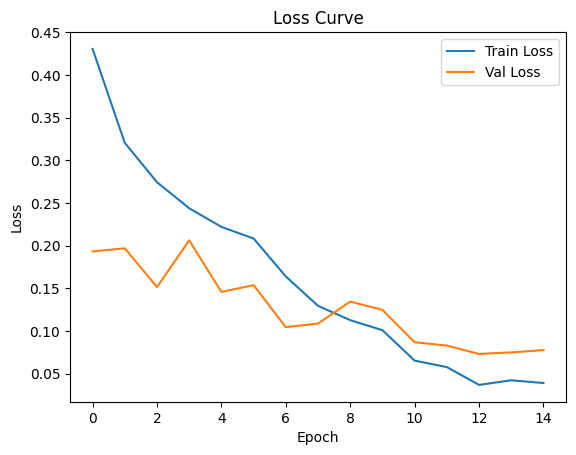

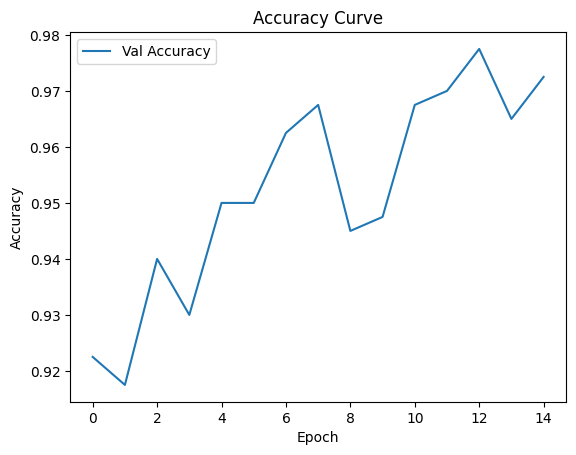

In [13]:
src = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset"
dst = "/kaggle/working/cleaned_dataset"
train_dir = "/kaggle/working/train"
val_dir = "/kaggle/working/val"

copy_and_clean_dataset(src, dst)
split_dataset(dst, train_dir, val_dir)

train_loader, val_loader = get_loaders(train_dir, val_dir, batch_size=4)
model = build_model()
train(model, train_loader, val_loader, num_epochs=15, lr=1e-4)

In [14]:
def predict_video(model, video_path, transform, frames_per_clip=8):
    model.eval()
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < frames_per_clip:
        frame_indices = np.concatenate([
            np.arange(total_frames),
            np.full(frames_per_clip - total_frames, total_frames - 1)
        ])
    else:
        frame_indices = np.linspace(0, total_frames - 1, frames_per_clip, dtype=int)

    frames = []
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret or frame is None:
            raise ValueError("Failed to read frame.")
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (112, 112))
        frame = transform(frame)
        frames.append(frame)
    cap.release()

    video_tensor = torch.stack(frames).permute(1, 0, 2, 3).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(video_tensor)
        prediction = torch.argmax(output, dim=1).item()
        confidence = torch.softmax(output, dim=1).squeeze()[prediction].item()

    return prediction, confidence


In [15]:
video_path = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/V_1000.mp4"
prediction, confidence = predict_video(model, video_path, transform)

label = "Violence" if prediction == 1 else "NonViolence"
print(f"Prediction: {label} (Confidence: {confidence:.2f})")


Prediction: Violence (Confidence: 1.00)


In [16]:
torch.save(model.state_dict(), "violence_detection_model.pth")
